Unlike in the Prediction notebook, the goal here is to find the factors that best explain variation in cancer death rates. So I will use LassoCV here to do that, as well as a simple decision tree.   
As in the Prediction notebook, I will:  
1. Remove features that have large numbers of zero values  
2. Transform and scale the data with Power Transformer to reduce skew that could impact model performance and ensure that the feature weights are scaled similarly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import tree
from sklearn.metrics import r2_score
import math

#load training and test data
dataset_orig = pd.read_csv('cleanData.csv')

In [2]:
#A function to drop the categorical features from the dataframe
def dropCat(data):
    return data.drop(['Area Code','Area Name','parent_name','parent_area',
                     'typhoid','measles','hepatitis','STEC','giardia','shigella','listeria','mumps','IMD'],axis=1)

In [3]:
pt = PowerTransformer()
dataset=pd.DataFrame(pt.fit_transform(dropCat(dataset_orig)),columns=dropCat(dataset_orig).columns)

## Correlation

In [4]:
#view the correlation of each feature to cancer death rates in descending order
correlation_checker = pd.DataFrame(dataset.corr()['cancer_death_rate'])
correlation_checker.iloc[(-correlation_checker.cancer_death_rate.abs()).argsort()]

,cancer_death_rate
cancer_death_rate,1.000000
cardiovascular,0.727054
respiratory,0.692244
mental,0.650118
education,-0.627982
Five_a_day,-0.573109
back_pain,0.570413
alcohol,0.551816
diabetes,0.495563
inactive,0.485806


In [18]:
#create X and Y
X = dataset.drop('cancer_death_rate',axis=1)
Y = dataset['cancer_death_rate']

## Lasso

In [19]:
#get best lassoCV outcome
lasso = LassoCV()
lasso.fit(X,Y)
lasso_predict = lasso.predict(X)
best_alpha = lasso.alpha_
coefs = lasso.coef_
r2 = r2_score(Y, lasso_predict)
print('r2: ',r2)
print('alpha: ',best_alpha)
#make table of coefficients
table_lasso = [X.columns, coefs]
table_lasso = pd.DataFrame(table_lasso).T.rename(columns={0:'feature',1:'coef'})
table_lasso['abs_coef'] = abs(table_lasso['coef'])
table_lasso = table_lasso[table_lasso.abs_coef>0]
print(table_lasso.sort_values(by='abs_coef', ascending=False))

r2:  0.6459952941137124
alpha:  0.06780533804419876
             feature       coef   abs_coef
16    cardiovascular   0.314084   0.314084
17       respiratory    0.22073    0.22073
30         education  -0.103718   0.103718
26          diabetes  0.0590018  0.0590018
7   comm_disease_flu  0.0581872  0.0581872
25         back_pain  0.0570215  0.0570215
13            mental  0.0448131  0.0448131
27               MSK  0.0396176  0.0396176
19        indoor_air -0.0364591  0.0364591
22         pollution -0.0146927  0.0146927
8        antibiotics  0.0101099  0.0101099


Above: By using the whole dataset here rather than just the training set (which I was limited to in the Prediction notebook), Lasso results in just 11 features out of 32 (as opposed to the 24 features in the Prediction notebook).  
As in the Prediction notebook, **cardiovascular, respiratory, and education** top the list.



It's easy to imagine that regions with higher than average death rates from health conditions like cardiovascular or respiratory disease would also see higher than average death rates from cancer -- perhaps due to poorer health services in a particular region. Regions with underfunded health services may also be underfunding education services. So below, I'll drop these features one by one to see if the model still has predictive power without them.

In [23]:
dropper = X.copy()
features_to_drop = ['cardiovascular','respiratory','education','diabetes','comm_disease_flu','back_pain','mental',
                    'MSK']
dropped = []
score = []
for feature in features_to_drop:
    dropper = dropper.drop(feature, axis=1)
    dropped.append(feature)
    lasso = LassoCV()
    lasso.fit(dropper,Y)
    lasso_predict = lasso.predict(dropper)
    coefs = lasso.coef_
    score.append(r2_score(Y, lasso_predict))
    #make table of coefficients
    table_dropped = [dropped, score]
    table_dropped = pd.DataFrame(table_dropped).T.rename(columns={0:'dropped',1:'score'})
print('Model score as each additional feature is dropped')
print(table_dropped)
print('')
print('Next best predictors after above features have been dropped')
table_lasso = [dropper.columns, coefs]
table_lasso = pd.DataFrame(table_lasso).T.rename(columns={0:'feature',1:'coef'})
table_lasso['abs_coef'] = abs(table_lasso['coef'])
table_lasso = table_lasso[table_lasso.abs_coef>0]
print(table_lasso.sort_values(by='abs_coef', ascending=False))

Model score as each additional feature is dropped
            dropped     score
0    cardiovascular   0.60288
1       respiratory  0.554526
2         education  0.537902
3          diabetes  0.524665
4  comm_disease_flu  0.516823
5         back_pain  0.493322
6            mental  0.481735
7               MSK  0.425224

Next best predictors after above features have been dropped
        feature       coef   abs_coef
20   Five_a_day  -0.251603   0.251603
17      alcohol    0.23116    0.23116
18    pollution -0.0687308  0.0687308
19     inactive  0.0545582  0.0545582
7   antibiotics  0.0501836  0.0501836
23    premature   0.035222   0.035222


Above we see that even if we drop the main health-related factors -- cardiovascular, respiratory, diabetes, communicable diseases, back_pain, mental, and musculoskeletal -- we're still able to account for 42% of disparity in cancer death rates across communities with factors such as Five-a-day, alcohol, pollution, inactivity, antibiotics, and prematurity. Still, several of these factors would likely also correlate to areas with less well-funded social and health services. A follow-up analysis that looks at wealth, health care funding, hospital bed count/population, doctor and nurse count/population, etc., would help to shed light on whether such factors are indeed the main contributors.

## Decision Tree

In [6]:
#Keep only the features identified as important by the Lasso regression above
subsetKill = table_lasso[table_lasso['abs_coef']==0]['feature'].tolist()
subsetData = X.drop(columns=subsetKill)
#Run regression tree model and print the r-squared
dTree = tree.DecisionTreeRegressor(max_depth=4)
dTree.fit(X, Y)
dTree_predict = dTree.predict(X)
r2 = r2_score(Y,dTree_predict)
print('r2: ', r2)

r2:  0.7441722182890375


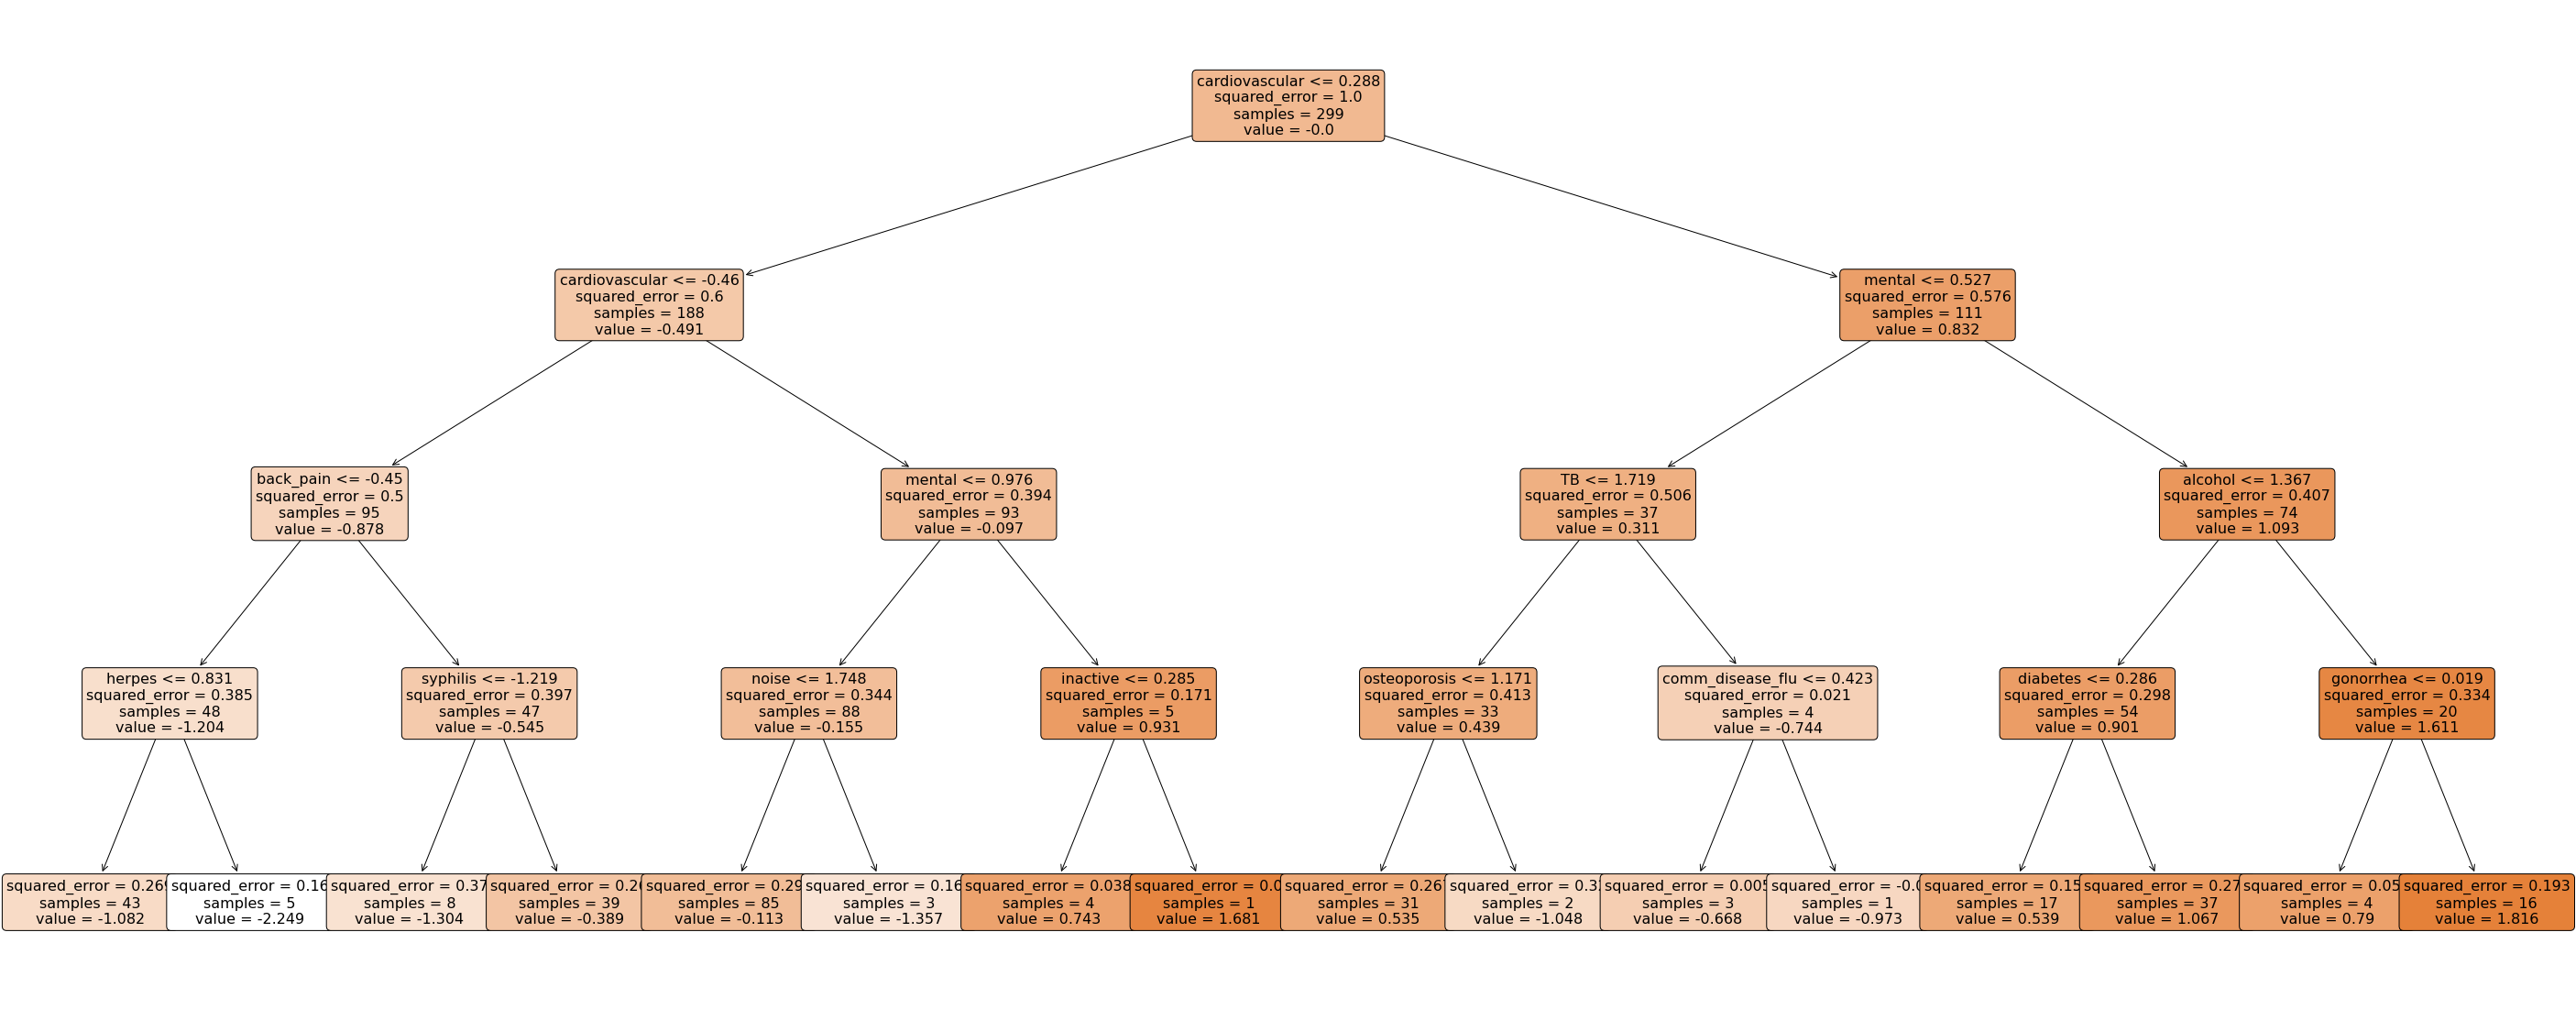

In [7]:
plt.figure(figsize=(50,20))  
_ = tree.plot_tree(dTree, feature_names = X.columns, 
             filled=True, fontsize=16, rounded = True)
plt.show()

In [8]:
#view features in terms of decision importance
treeTable = [X.columns, dTree.feature_importances_]
treeTable = pd.DataFrame(treeTable).T.rename(columns={0:'feature',1:'importance'})
treeTable = treeTable[treeTable['importance']>0]
treeTable.sort_values(by='importance', ascending=False)

,feature,importance
16,cardiovascular,0.678395
13,mental,0.0928544
25,back_pain,0.0463227
21,alcohol,0.0330368
4,herpes,0.0274241
1,syphilis,0.0249882
6,TB,0.0224542
18,osteoporosis,0.0211624
14,noise,0.020166
2,gonorrhea,0.0151264


Above: Using a decision tree, we identify  
**cardiovascular, mental, back pain, and alcohol**  
as the most influential. 

However, several sexually transmitted diseases also factor in (herpes, syphilis, gonorrhea).

## Linear relationship    
Below: If we look purely at linear relationships between each feature and cancer death rates,   
**cardiovascular, mental, respiratory, education, back pain, Five-a-day, and alcohol**  
have the clearest linear patterns.

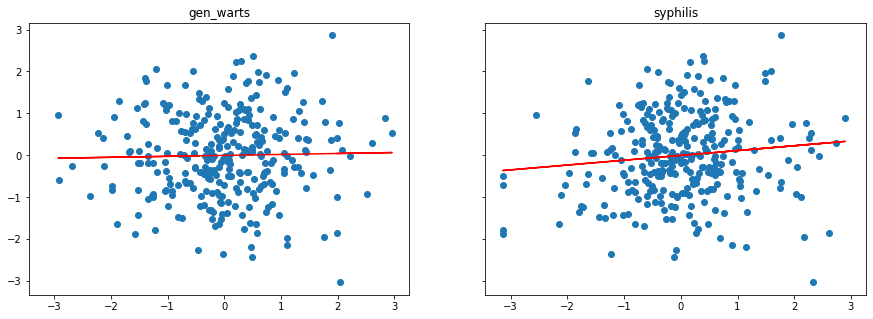

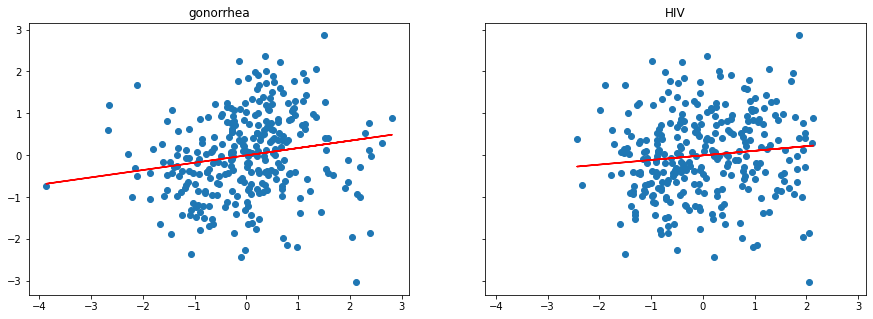

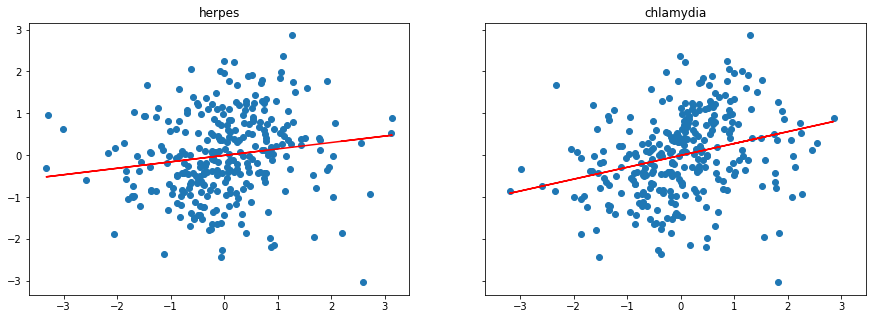

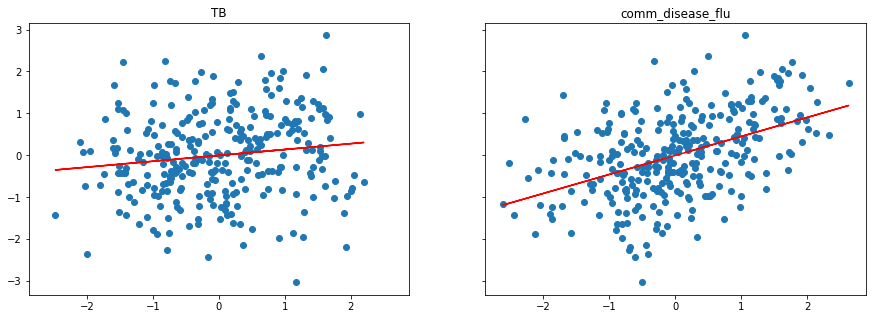

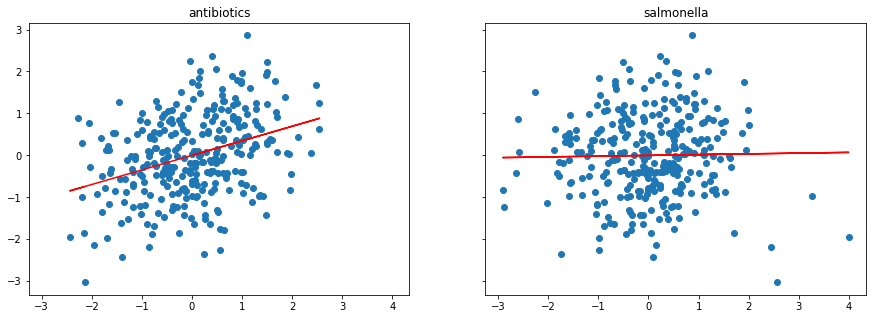

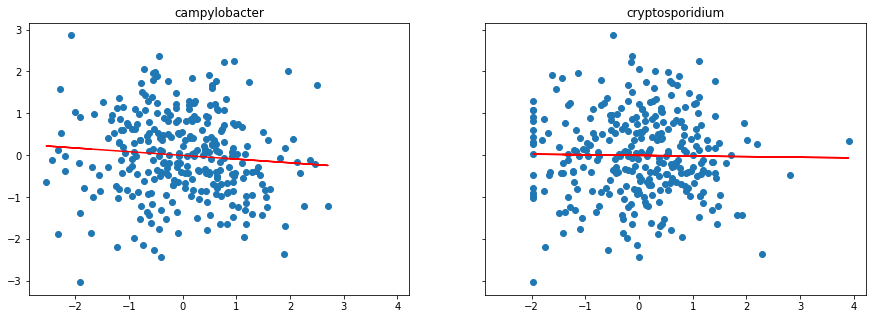

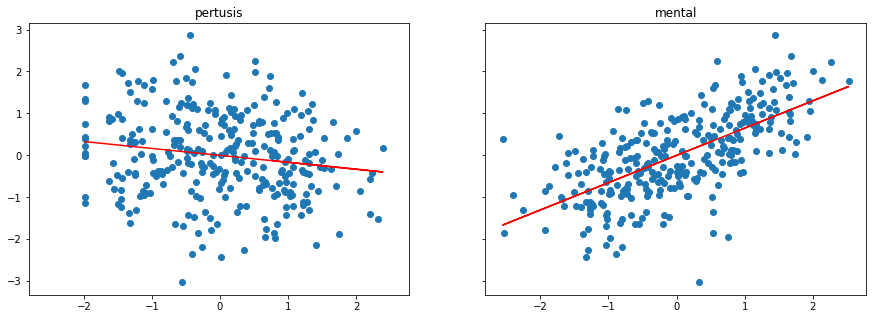

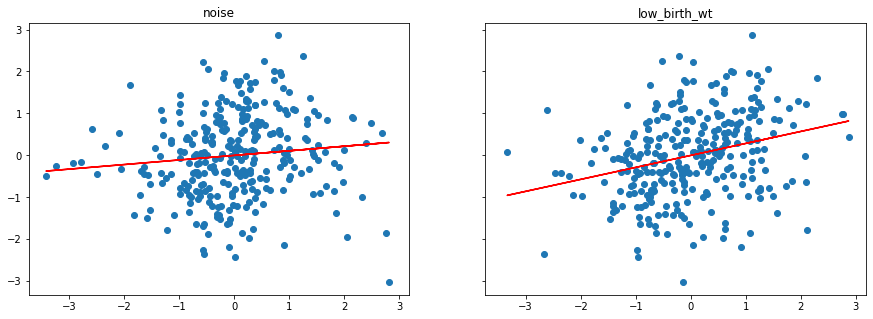

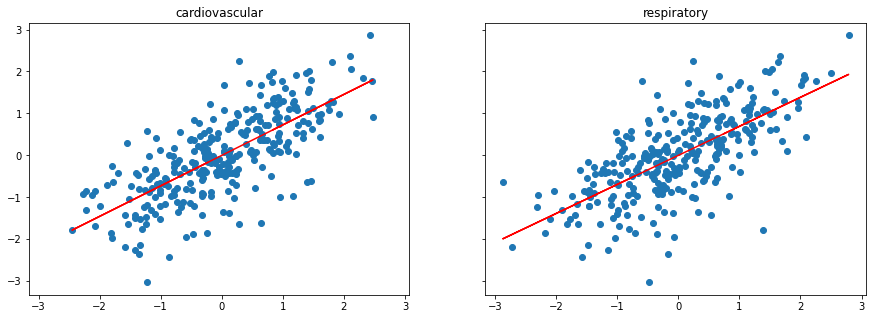

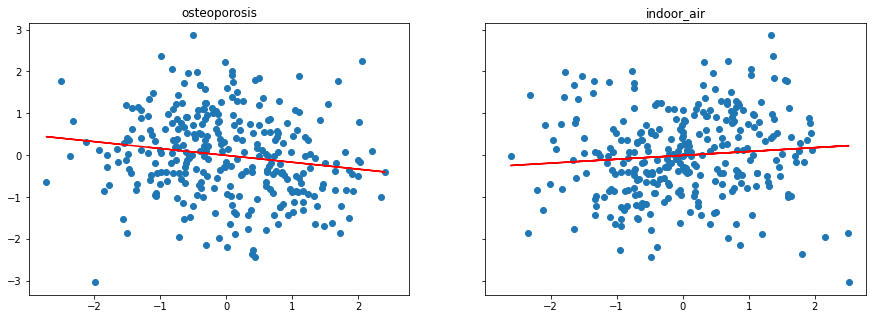

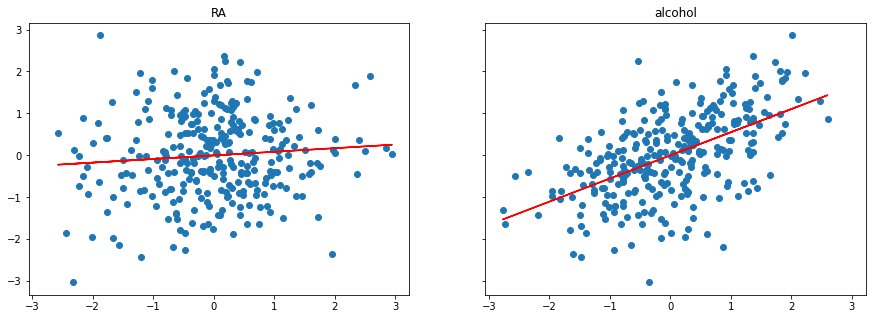

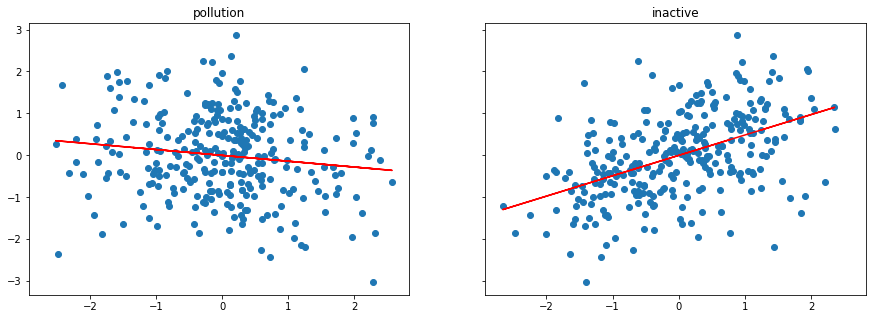

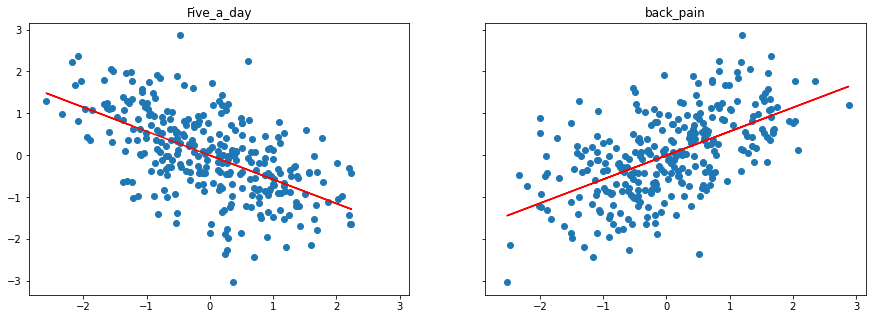

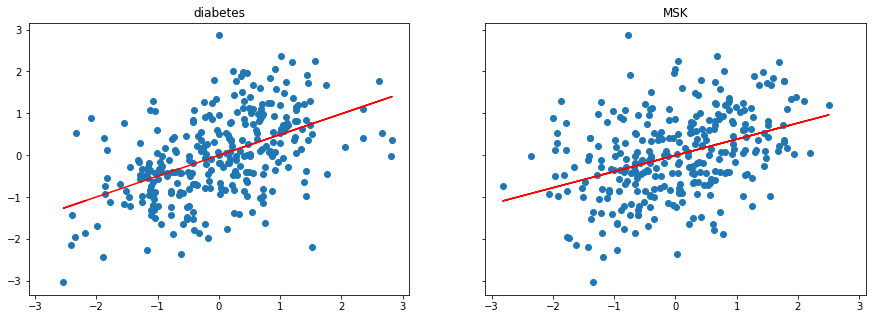

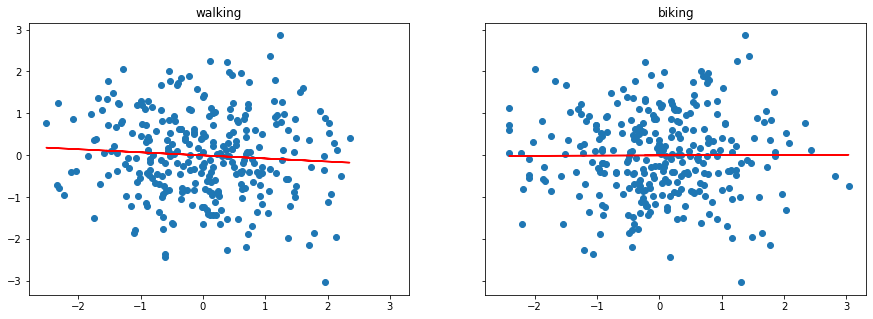

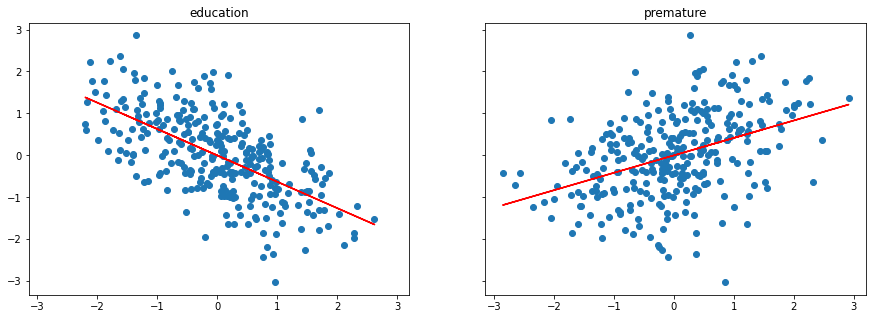

In [9]:
counter=0
row = 0
for pair in range(0,math.floor(len(X.columns)/2)):
    figure, axis = plt.subplots(1, 2, figsize=(15,5),sharex=True, sharey=True, squeeze=False)
    x= X[X.columns[counter]]
    axis[row, 0].scatter(x,Y)
    axis[row, 0].set_title(X.columns[counter])
    m, b = np.polyfit(x,Y, 1)
    axis[row, 0].plot(x, m*x+b, color='r')
    if pair*2<=len(X.columns):
        x= X[X.columns[counter+1]]
        axis[row, 1].scatter(x,Y)
        axis[row, 1].set_title(X.columns[counter+1])
        m, b = np.polyfit(x,Y, 1)
        axis[row, 1].plot(x, m*x+b, color='r')
        counter+=2
    else:
        continue


## Feature descriptions

Here are the full descriptions of each of the features highlighted above by Lasso, decision tree, or linearity:

**cardiovascular** -- 'Under 75 mortality rate from all cardiovascular diseases'

**respiratory** -- 'Under 75 mortality rate from respiratory disease'

**education** -- 'Educational attainment (5 or more GCSEs): % of all children'

**diabetes** -- 'Estimated diabetes diagnosis rate'

**comm_disease_flu** -- 'Mortality rate from a range of specified communicable diseases, including influenza'

**back_pain** -- 'Prevalence of hip osteoarthritis in people aged 45 and over'

**mental** -- 'ESA claimants for mental and behavioural disorders: rate per 1,000 working age population'

**MSK** -- 'Percentage reporting a long term Musculoskeletal (MSK) problem'

**indoor_air** -- 'Quality of indoor living environment: IMD score'

**pollution** -- 'Air pollution: fine particulate matter'

**antibiotics** -- 'Adjusted antibiotic prescribing in primary care by the NHS'

**alcohol** -- 'Admission episodes for alcohol-related conditions (Broad)'

**Five-a-day** -- 'Proportion of the population meeting the recommended '5-a-day' on a 'usual day' (adults)'

In [ ]:
'''
#get best lassoCV outcome
pipe = make_pipeline(StandardScaler(),LassoCV())
pipe.fit(X,Y)
lasso_predict = pipe.predict(X)
best_alpha = pipe.named_steps['lassocv'].alpha_
coefs = pipe.named_steps['lassocv'].coef_
r2 = r2_score(Y, lasso_predict)
print('r2: ',r2)
print('alpha: ',best_alpha)
#make table of coefficients
table_lasso = [X.columns, coefs]
table_lasso = pd.DataFrame(table_lasso).T.rename(columns={0:'feature',1:'coef'})
table_lasso['abs_coef'] = abs(table_lasso['coef'])
table_lasso = table_lasso[table_lasso.abs_coef>0]
print(table_lasso.sort_values(by='abs_coef', ascending=False))
'''